In [60]:
from __future__ import print_function

import time
import requests
from bs4 import BeautifulSoup
import pymongo
import pandas as pd
import numpy as np
import re

from sklearn.externals import joblib

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnlzer = WordNetLemmatizer()


from pprint import pprint
from time import time
import logging


import sys
import os
import csv
import shutil
from collections import defaultdict
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
#import parfit.parfit as pf


import matplotlib.pyplot as plt

source_path = 'test_data'
#source_file = 'test_strains_reviews.csv'
target_path = '/Users/jordanweil/green_rex/test_data'

In [2]:
"""reviews = pd.read_csv('test_data/test_strains_reviews.csv')
r = reviews.set_index('Unnamed: 0')"""

"reviews = pd.read_csv('test_data/test_strains_reviews.csv')\nr = reviews.set_index('Unnamed: 0')"

In [3]:
def get_reviews2(l):
    """Pass in a list of URL's and return them in a mongo db table as a dicitonary with 
    {'url', 'html'} and their corresponding values"""
    r = requests.get(l)
    html = (r.content)
    return html

In [4]:
# def get_stars_list(d):
#     stars = []
#     for key, values in d.items():
#         soup = BeautifulSoup(values, 'html.parser')
#         tags = soup.select("div.div.stars")
#         for t in tags:
#             stars.append(t.attrs['style'])
#     return stars

In [5]:
def star_int_conv(s):
    star = (int((s[6:].split(';')[0]).strip('px'))/22)
    return star

In [6]:
def list_o_strains(i):
    LOS = []
    Type = []
    r = requests.get(i)
    soup2 = BeautifulSoup(r.content, 'html.parser')
    strains = soup2.find_all('a', class_="ga_Explore_Strain_Tile")
    for s in strains:
        LOS.append(str(s.attrs['href'])[8:])
        Type.append(str(s.attrs['href'])[1:7])
    z = list(zip(LOS,Type))
    return z

In [7]:
def strain_dict_entry(strain, stype, user_id, userstars, userreview, straindict):
    if straindict is None:
        straindict = {}
        
    if strain not in straindict:
        straindict[strain] = {
            "stype" : stype,
            "user_rev" : [] 
        }
        
    straindict[strain]['user_rev'].append({'user':user_id,
                                         'stars':userstars,
                                         'review':userreview
                                        })
    return straindict

In [8]:
def parse_docs2(d):
    """Parse the HTML docs that we have stored in a dictionary, return as a list.
    Also scrape and parse star rating for each review """
    strain_text= []
    star_rate = []
    user_name = []
    
    soup = BeautifulSoup(d, 'html.parser')
    revs = soup.find_all('p',class_='strain-review__text') 
    for r in revs:
        text = r.text
        remove_punch = re.sub('[^A-Za-z ]' , "" ,text )
        token = remove_punch.lower().split()
        srm_token = [wnlzer.lemmatize(i) for i in token if not i in set(stopwords.words('english'))]
        clean_text = " ".join(srm_token)
        strain_text.append(clean_text)
        
    tags = soup.select("div.div.stars")
    for t in tags:
        star = t.attrs['style']
        star_rate.append(star_int_conv(star))
    
    users = soup.find_all('div', class_='strain-review__title')
    for u in users:
        temp = u.find('h2')
        user_name.append(temp.text)
        
    return star_rate, strain_text, user_name

In [9]:
def scraper_dummy1(los):
    """pass in a list of strains to be scraped from Leafly.
    returns dictionary keyed by strains w/strain info(reviews) as values"""
    cnt = 0
    strain_dict = None
    for s in los:
        strain = s[0]
        stype = s[1]
        url = "https://www.leafly.com/{}/{}/reviews?page=".format(stype, strain)
    
        for i in range(1,100):
            rev_url=url+str(i)
            d = get_reviews2(rev_url)
            star, reviews, users = parse_docs2(d)
            #print(star)
            if len(star) == 0:
                break

            for userstars, userreview ,user_id in zip(star, reviews, users):
                strain_dict = strain_dict_entry(strain, stype, user_id, userstars, userreview, strain_dict)
                
            
            if cnt % 10 == 0:
                print(cnt)
            cnt +=1
            
    return strain_dict         

In [10]:
test_strains = list_o_strains('https://www.leafly.com/explore')

In [11]:
test_strains

[('blue-dream', 'hybrid'),
 ('sour-diesel', 'sativa'),
 ('gsc', 'hybrid'),
 ('green-crack', 'sativa'),
 ('og-kush', 'hybrid'),
 ('granddaddy-purple', 'indica'),
 ('original-glue', 'hybrid'),
 ('white-widow', 'hybrid'),
 ('blue-dream', 'hybrid'),
 ('sour-diesel', 'sativa'),
 ('gsc', 'hybrid'),
 ('green-crack', 'sativa'),
 ('og-kush', 'hybrid'),
 ('granddaddy-purple', 'indica'),
 ('original-glue', 'hybrid'),
 ('white-widow', 'hybrid'),
 ('jack-herer', 'sativa'),
 ('bubba-kush', 'indica'),
 ('pineapple-express', 'hybrid'),
 ('trainwreck', 'hybrid'),
 ('ak-47', 'hybrid'),
 ('durban-poison', 'sativa'),
 ('northern-lights', 'indica'),
 ('headband', 'hybrid'),
 ('blue-cheese', 'indica'),
 ('strawberry-cough', 'sativa'),
 ('chemdawg', 'hybrid'),
 ('purple-kush', 'indica'),
 ('lemon-haze', 'sativa'),
 ('super-lemon-haze', 'sativa'),
 ('grape-ape', 'indica'),
 ('blueberry', 'indica'),
 ('alaskan-thunder-fuck', 'sativa'),
 ('super-silver-haze', 'sativa'),
 ('blackberry-kush', 'indica'),
 ('cherry

In [12]:
"""#Only needs to be ran once
d = scraper_dummy1(test_strains)"""

#Already ran it!

'#Only needs to be ran once\nd = scraper_dummy1(test_strains)'

In [13]:
for k in d.keys():
    print(k,len(d[k]['user_rev']))

NameError: name 'd' is not defined

In [34]:
d['gsc']['user_rev'][3]

NameError: name 'd' is not defined

In [41]:
def create_files(d):
    cnt = 0
    for strain in d.keys():

        if not os.path.isdir(os.path.join(target_path, strain)):
             os.mkdir(os.path.join(target_path, strain))

        for rev in d[strain]['user_rev']:

            with open(os.path.join(target_path, strain, strain+'{:05d}.txt'.format(cnt)), mode='w') as strain_file:
                strain_file.write(rev['review'])

            cnt += 1

In [42]:
create_files(d)

In [16]:
stopwords_ = "a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your]".split(',')

In [52]:
    dataset = load_files(target_path, shuffle=False)
    print('n_samples {}'.format(len(dataset.data)))

    # split the dataset in training and test set:
    docs_train, docs_test, y_train, y_test = train_test_split(
        dataset.data, dataset.target, test_size=0.15, random_state=None)

    
    
    # #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80),
}


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
        grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(docs_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    
    
    
    
filename = 'finalized_model.sav'
joblib.dump(model, filename)
    
    
    
    
""" # TASK: Build a vectorizer / classifier pipeline that filters out tokens
    # that are too rare or too frequent
    clf = Pipeline([
        ('vect',TfidfVectorizer(analyzer='character', stop_words=stopwords_)),
        ('clf', Perceptron())
    ])

    # TfidfVectorizer().get_params()
    # TASK: Build a grid search to find out whether unigrams or bigrams are
    # more useful.
    # Fit the pipeline on the training set using grid search for the parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 5), (1,10),(1,20)],
        'vect__analyzer': ['word']#,'char']
    }
    
    
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    cclf = gs_clf.fit(docs_train, y_train)"""

n_samples 9000
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (10, 50, 80),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 111.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 128.2min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 177.3min
[Par

done in 13701.829s

Best score: 0.539
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 80
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 1.0
	vect__max_features: None
	vect__ngram_range: (1, 2)


" # TASK: Build a vectorizer / classifier pipeline that filters out tokens\n# that are too rare or too frequent\nclf = Pipeline([\n    ('vect',TfidfVectorizer(analyzer='character', stop_words=stopwords_)),\n    ('clf', Perceptron())\n])\n\n# TfidfVectorizer().get_params()\n# TASK: Build a grid search to find out whether unigrams or bigrams are\n# more useful.\n# Fit the pipeline on the training set using grid search for the parameters\nparameters = {\n    'vect__ngram_range': [(1, 1), (1, 5), (1,10),(1,20)],\n    'vect__analyzer': ['word']#,'char']\n}\n\n\ngs_clf = GridSearchCV(clf, parameters, n_jobs=-1)\ncclf = gs_clf.fit(docs_train, y_train)"

{'vect__analyzer': 'word', 'vect__ngram_range': (1, 5)}
0.9296296296296296
                      precision    recall  f1-score   support

  .ipynb_checkpoints       0.25      1.00      0.40         1
         afghan-kush       0.90      0.90      0.90        10
        agent-orange       0.89      0.80      0.84        10
               ak-47       0.95      0.80      0.87        25
alaskan-thunder-fuck       0.89      0.89      0.89         9
        amnesia-haze       0.86      0.96      0.91        25
     blackberry-kush       0.89      0.80      0.84        10
         blue-cheese       0.75      0.92      0.83        13
          blue-dream       0.94      0.98      0.96       147
           blueberry       0.73      0.79      0.76        14
          bubba-kush       0.97      0.88      0.92        34
              cheese       1.00      0.60      0.75         5
            chemdawg       0.93      0.78      0.85        18
          cherry-pie       0.85      1.00      0.92     

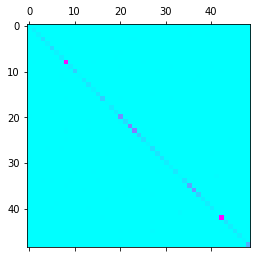

In [53]:
# TASK: Predict the outcome on the testing set in a variable named y_predicted
y_predicted = gs_clf.predict(docs_test)

print(gs_clf.best_params_)
print(cclf.score(docs_test, y_test))

# Print the classification report
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

# Plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
#print(cm)

plt.matshow(cm, cmap=plt.cm.cool)
plt.show()

In [57]:
test_strings = [
    u'yawn sore tired',
    u'smile laugh giggle',
    u'happy hike energy',
    u'fun'
]

predicted = cclf.predict(test_strings)

for s, p in zip(test_strings, predicted):
    print(u'To feel these like ({}) try smoking {}'.format(s, dataset.target_names[p]))


To feel these like (yawn sore tired) try smoking purple-urkle
To feel these like (smile laugh giggle) try smoking green-crack
To feel these like (happy hike energy) try smoking green-crack
To feel these like (fun) try smoking ak-47
